# Data Augmentation

Data Augmentation is basically artificially increasing the training set size by transformations such as zooming, rotating, and changing brightness. The two main branches of data augmentation in Tensorflow are for image and sequence data.<br>
To make things a little more complicated, TensorFlow (tf.image), Keras (tf.keras.preprocessing), and tf.keras.layers have data augmentation options. One is not better than the other, but stick to one in your code!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Image Augmentation
A lot, but not all of this information can be referenced here: https://www.tensorflow.org/tutorials/images/data_augmentation

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2022-02-21 22:15:21.434958: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 22:15:24.398399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9640 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2022-02-21 22:15:24.399839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9640 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2022-02-21 22:15:24.401148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/r

2022-02-21 22:29:18.427110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-21 22:29:18.474552: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


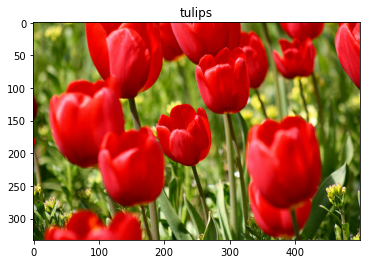

In [20]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

>### tf.keras.layers
There are many preprocessing keras layers, but below are a few examples. These layers can be attached to the beginnning of your model or to the end of your dataset object. If they are part of the model they will only be active and mess with the input during training mode, during testing mode they are inactive.
>>#### RandomFlip
>>#### RandomRotation
>>#### RandomZoom
>>#### Random Transelation
>>#### Random Brightness
>>#### GaussianNoise

In [21]:
from tensorflow.keras import layers

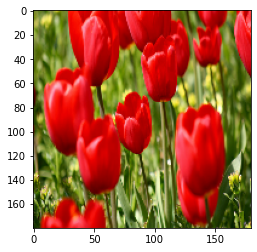

In [22]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.imshow(result)

>>#### Applying layers at the beginning of the model

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(.5),
  layers.RandomZoom((-.5, 0))
    ## Rest of the model
])

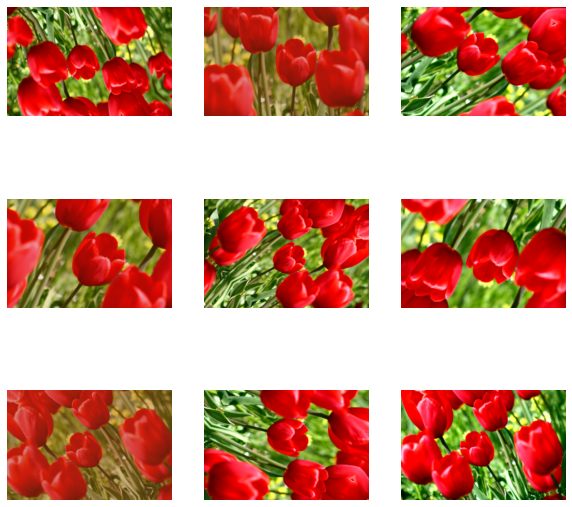

In [24]:
# Add the image to a batch.
batch_image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(batch_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

>>### Applying layers at the end of a dataset
**Note:** You are basically using the dataset.map function to send the images through a tf.keras.Sequential model.<br>
**IMPORTANT NOTE:** When you do this on the end of a dataset these operations actually get done on the CPU, and since prefetch was called the augmentation of one batch can be done in parallel while the model is training on the previous batch !

In [25]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

>### tf.keras.preprocessing.image.ImageDataGenerator
This doesn't seem to have an interface for tf.data.dataset objects, it is built to take input from numpy arrays, pandas dataframes, and file systems.
**NOTE:** If you are pulling images directly from a folder than this one might be most convenient, read the docs for **.flow_from_directory** : https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory <br>
and/or **DirectoryIterator**: https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator

In [26]:
import os
directory_path = os.getcwd()
directory_path

'/blue/cis4905/sumanth/WeeklyNotes/Unit 3'

In [27]:
flowers = tf.keras.utils.get_file(
    f'{directory_path}/flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
print(f'Flowers Dataset now located here: {flowers}')

Flowers Dataset now located here: /blue/cis4905/sumanth/WeeklyNotes/Unit 3/flower_photos


In [28]:
import tarfile
file = tarfile.open('./flower_photos.tar.gz')
file.extractall('./')
file.close()

In [29]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          rotation_range=20,
                                                         zoom_range=.5,
                                                         channel_shift_range=10)
directory_iterator = img_gen.flow_from_directory(flowers)

Found 4455 images belonging to 6 classes.


Text(0.5, 1.0, '[0. 0. 0. 0. 1. 0.]')

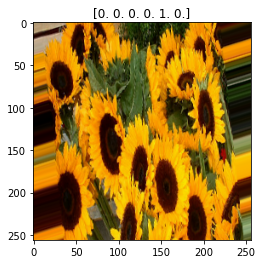

In [30]:
j = 4

images, labels = next(directory_iterator)

plt.imshow(images[j])
plt.title(labels[j])

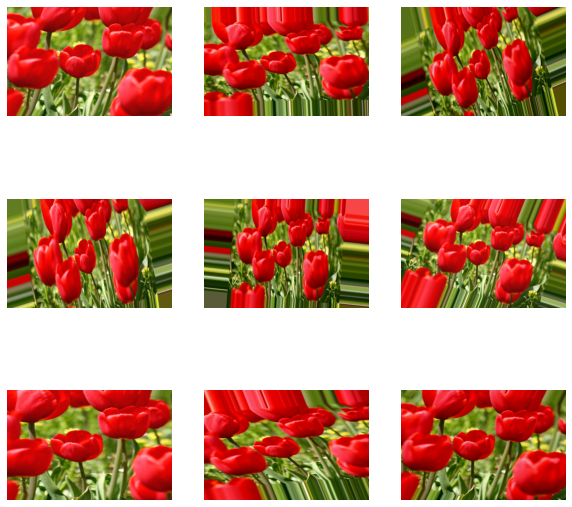

In [41]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = next(img_gen.flow(batch_image))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

>### tf.image

In [117]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2022-02-21 23:01:36.863226: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


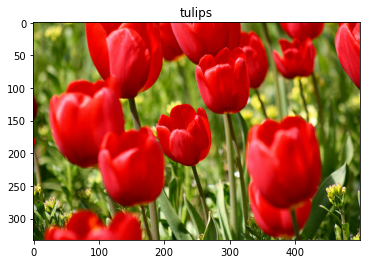

In [118]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [119]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

#### **NOTE!**
It is strongly discouraged to use teh tf.image.random... functions. They use an older way of getting rng, instead you should use tf.image.stateless_random... and suppy your own seeds.

In [120]:
def augment(image, label):
  new_seed = tf.random.experimental.stateless_split([1,2], num=1)[0, :]
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 20, IMG_SIZE + 20)
#   Random crop back to the original size.
  image = tf.image.stateless_random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3], seed = new_seed)
#   Random brightness.
  image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed = new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [121]:
train_ds = train_ds.shuffle(1000).map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
test_ds = test_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

2022-02-21 23:01:40.814413: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


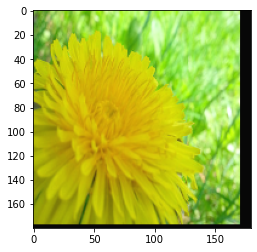

In [122]:
images, labels = iter(train_ds).get_next()
plt.imshow(images[0])

## Sequence Augmentation

# tf.transform